# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


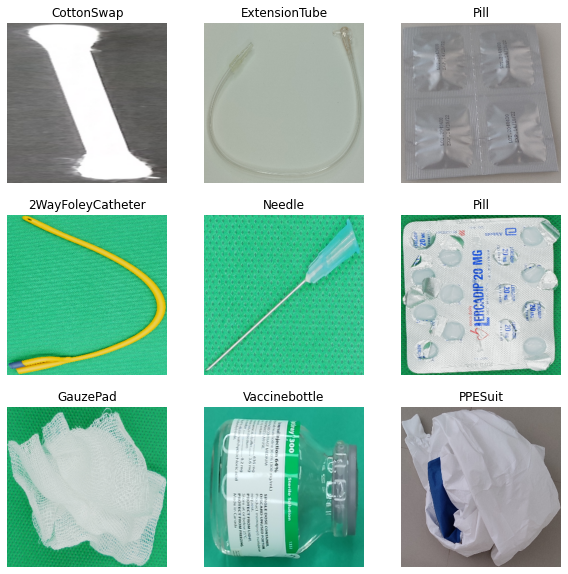

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


## Class Weight

In [21]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

In [22]:
print(len(y_train))
print(y_train)

12274
[ 2  0 19 ...  1 29 23]


In [23]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}
print(class_weight_value)

{0: 1.1832642437096308, 1: 1.104671046710467, 2: 1.0886031042128603, 3: 1.0886031042128603, 4: 0.8677271120537292, 5: 1.076855588699772, 6: 1.100609756097561, 7: 1.0147995039272426, 8: 1.1170367673825992, 9: 1.065358909816856, 10: 1.069163763066202, 11: 1.2022725046527574, 12: 1.0925761082428342, 13: 1.0846588900671617, 14: 1.1254355400696865, 15: 1.160332766118359, 16: 0.7559743779255974, 17: 1.1087624209575428, 18: 0.8090969017798286, 19: 1.057829871584935, 20: 1.1087624209575428, 21: 1.112884214344002, 22: 0.7617451747036554, 23: 0.9815273890443822, 24: 1.0045834015387134, 25: 0.9384509519076382, 26: 0.46413310644734357, 27: 0.9595059412132583, 28: 1.0252255262278651, 29: 1.072995891249235, 30: 1.121220425687403, 31: 0.9127007733491969, 32: 1.0504065040650405, 33: 1.1339615668883962, 34: 1.129682466635987, 35: 1.1382732078271354, 36: 1.035868005738881, 37: 1.0886031042128603, 38: 1.035868005738881, 39: 0.918300164596738, 40: 0.978319783197832}


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
192/192 [==============================] - 65s 299ms/step - loss: 0.7921 - accuracy: 0.8478 - val_loss: 0.2038 - val_accuracy: 0.9733
Epoch 2/2000
192/192 [==============================] - 34s 176ms/step - loss: 0.1394 - accuracy: 0.9828 - val_loss: 0.0991 - val_accuracy: 0.9919
Epoch 3/2000
192/192 [==============================] - 34s 176ms/step - loss: 0.0742 - accuracy: 0.9938 - val_loss: 0.0630 - val_accuracy: 0.9951
Epoch 4/2000
192/192 [==============================] - 34s 177ms/step - loss: 0.0480 - accuracy: 0.9969 - val_loss: 0.0450 - val_accuracy: 0.9964
Epoch 5/2000
192/192 [==============================] - 34s 177ms/step - loss: 0.0341 - accuracy: 0.9981 - val_loss: 0.0345 - val_accuracy: 0.9971
Epoch 6/2000
192/192 [==============================] - 34s 177ms/step - loss: 0.0257 - accuracy: 0.9987 - val_loss: 0.0276 - val_accuracy: 0.9987
Epoch 7/2000
192/192 [==============================] - 34s 177ms/step - loss: 0.0202 - accuracy: 0.9990 - val_loss: 0

Text(0.5, 1.0, 'Training and Validation Accuracy')

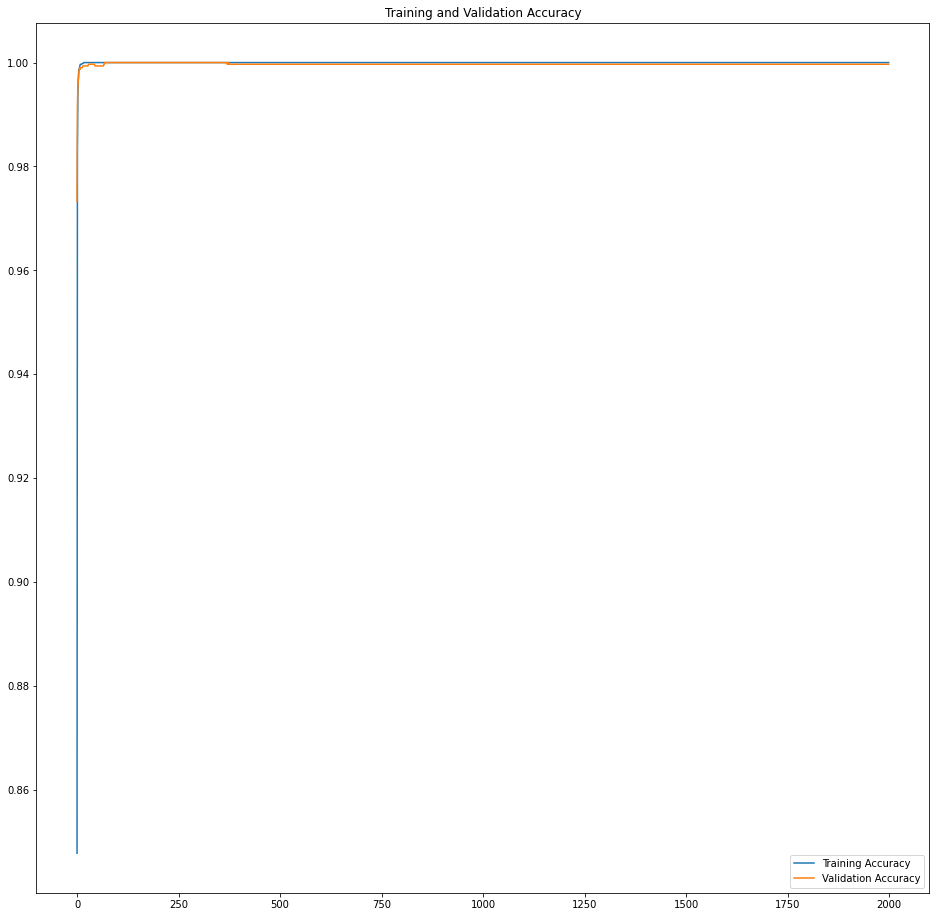

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


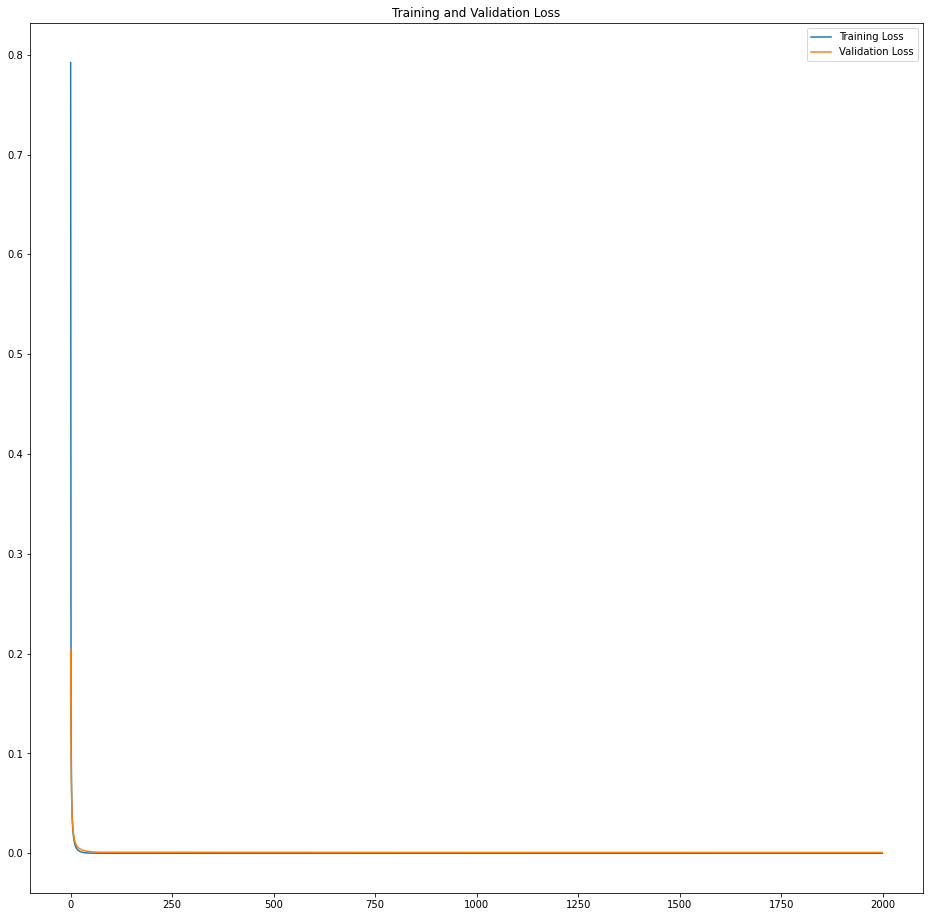

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 15s 375ms/step - loss: 0.7350 - accuracy: 0.8645
test_indoor_ds_results:test loss, test acc: [0.7349838018417358, 0.8645485043525696]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 28s 471ms/step - loss: 2.1743 - accuracy: 0.7503
test_outdoor_ds_results:test loss, test acc: [2.1742570400238037, 0.7503184676170349]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 207ms/step - loss: 2.2257 - accuracy: 0.7112
test_belt_ds_results:test loss, test acc: [2.225684881210327, 0.7112420797348022]


In [36]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0240-val_acc1.

# Testing in testset

In [37]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 144ms/step - loss: 1.4585 - accuracy: 0.7126
Epoch040 
 test_indoor_acc=0.8701226115226746 
 test_outdoor_acc=0.7519108057022095 
 test_belt_acc=0.7126020193099976
35/35 [==============================] - 5s 137ms/step - loss: 1.7747 - accuracy: 0.7112
Epoch080 
 test_indoor_acc=0.8678929805755615 
 test_outdoor_acc=0.7522292733192444 
 test_belt_acc=0.7112420797348022
35/35 [==============================] - 5s 141ms/step - loss: 1.7981 - accuracy: 0.7108
Epoch120 
 test_indoor_acc=0.8673355579376221 
 test_outdoor_acc=0.7525477409362793 
 test_belt_acc=0.7107887864112854
35/35 [==============================] - 5s 138ms/step - loss: 1.8307 - accuracy: 0.7112
Epoch160 
 test_indoor_acc=0.8690078258514404 
 test_outdoor_acc=0.7522292733192444 
 test_belt_acc=0.7112420797348022
35/35 [==============================] - 5s 140ms/step - loss: 1.8593 - accuracy: 0.7117
Epoch200 
 test_indoor_acc=0.8690078258514404 
 test_outdoor_acc=0.751592338085

In [38]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

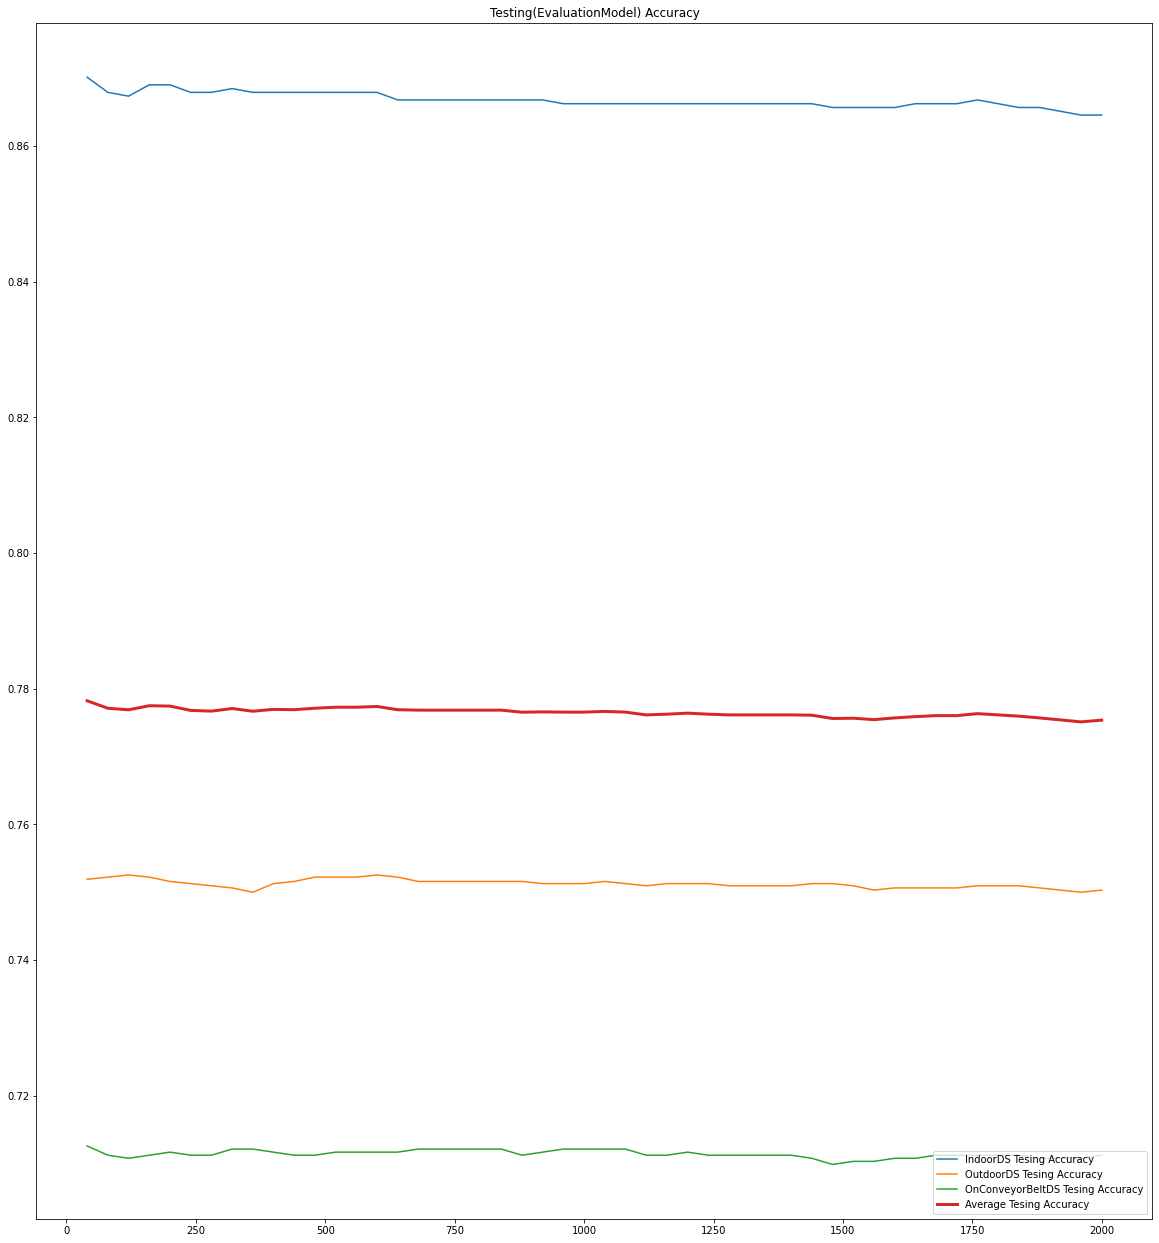

In [39]:
# loss / acc in each epoch graph ploting
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [40]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7782118121782938
max index -> 0
The [Epoch] of max acc -> 40


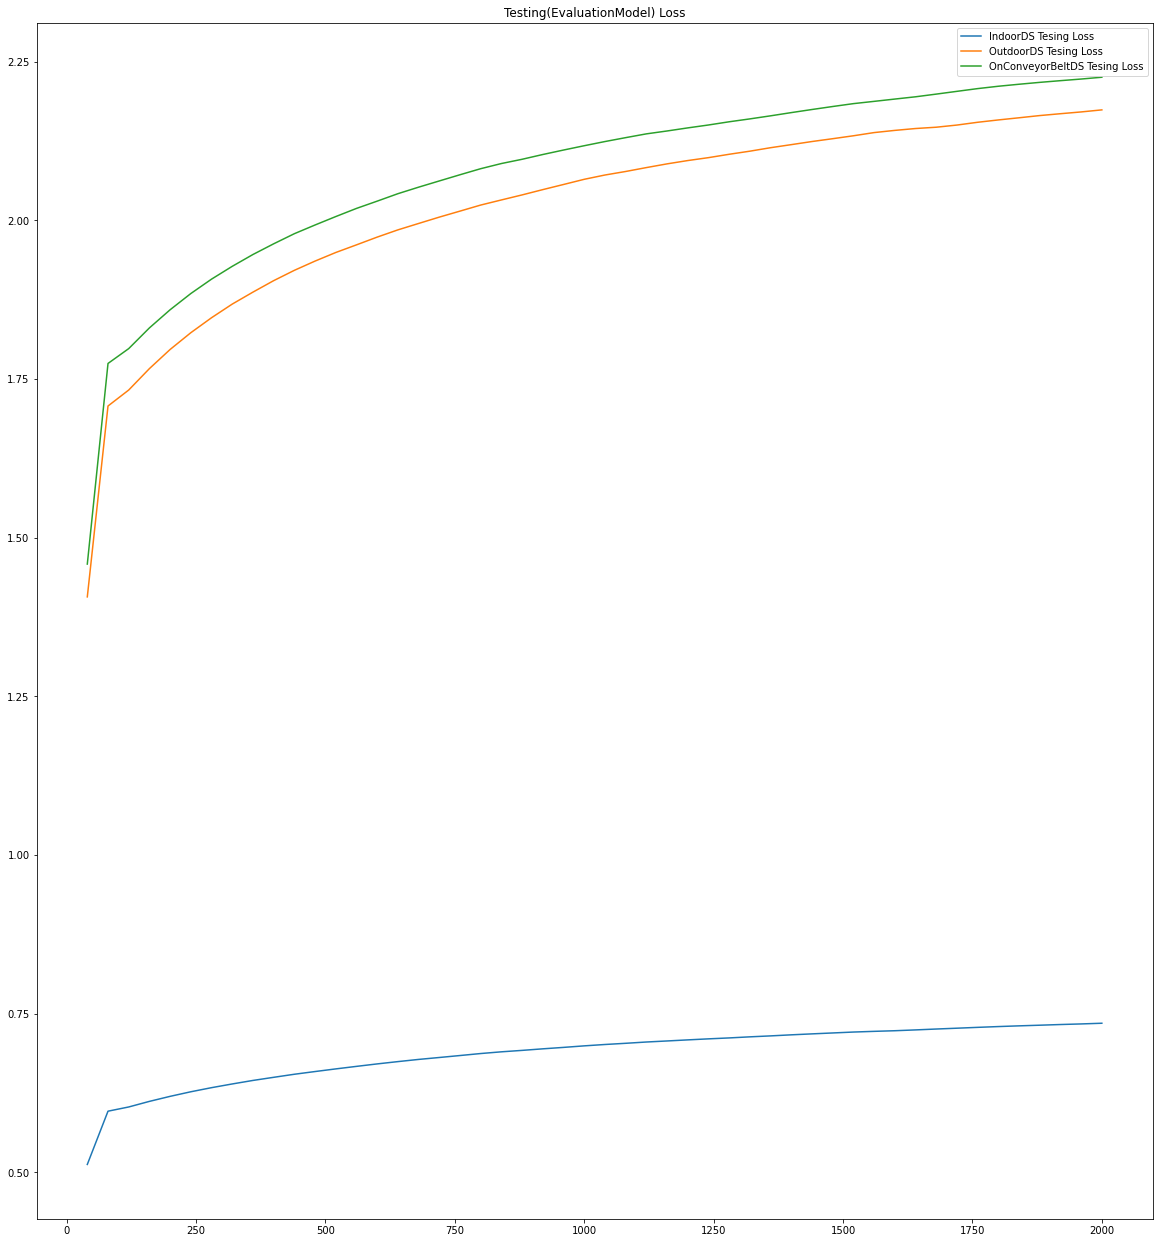

In [41]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [42]:
test_indoor_acc

[0.8701226115226746,
 0.8678929805755615,
 0.8673355579376221,
 0.8690078258514404,
 0.8690078258514404,
 0.8678929805755615,
 0.8678929805755615,
 0.868450403213501,
 0.8678929805755615,
 0.8678929805755615,
 0.8678929805755615,
 0.8678929805755615,
 0.8678929805755615,
 0.8678929805755615,
 0.8678929805755615,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8667781352996826,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8662207126617432,
 0.8662207126617432,
 0.8662207126617432,
 0.8667781352996826,
 0.8662207126617432,
 0.8656633496284485,
 0.8656633496284485,
 0.86510592699

In [43]:
test_outdoor_acc

[0.7519108057022095,
 0.7522292733192444,
 0.7525477409362793,
 0.7522292733192444,
 0.7515923380851746,
 0.7512738704681396,
 0.7509554028511047,
 0.7506369352340698,
 0.75,
 0.7512738704681396,
 0.7515923380851746,
 0.7522292733192444,
 0.7522292733192444,
 0.7522292733192444,
 0.7525477409362793,
 0.7522292733192444,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7512738704681396,
 0.7512738704681396,
 0.7512738704681396,
 0.7515923380851746,
 0.7512738704681396,
 0.7509554028511047,
 0.7512738704681396,
 0.7512738704681396,
 0.7512738704681396,
 0.7509554028511047,
 0.7509554028511047,
 0.7509554028511047,
 0.7509554028511047,
 0.7512738704681396,
 0.7512738704681396,
 0.7509554028511047,
 0.7503184676170349,
 0.7506369352340698,
 0.7506369352340698,
 0.7506369352340698,
 0.7506369352340698,
 0.7509554028511047,
 0.7509554028511047,
 0.7509554028511047,
 0.7506369352340698,
 0.7503184676170349,
 0.75,

In [44]:
test_belt_acc

[0.7126020193099976,
 0.7112420797348022,
 0.7107887864112854,
 0.7112420797348022,
 0.7116953730583191,
 0.7112420797348022,
 0.7112420797348022,
 0.7121486663818359,
 0.7121486663818359,
 0.7116953730583191,
 0.7112420797348022,
 0.7112420797348022,
 0.7116953730583191,
 0.7116953730583191,
 0.7116953730583191,
 0.7116953730583191,
 0.7121486663818359,
 0.7121486663818359,
 0.7121486663818359,
 0.7121486663818359,
 0.7121486663818359,
 0.7112420797348022,
 0.7116953730583191,
 0.7121486663818359,
 0.7121486663818359,
 0.7121486663818359,
 0.7121486663818359,
 0.7112420797348022,
 0.7112420797348022,
 0.7116953730583191,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7107887864112854,
 0.7098821401596069,
 0.7103354334831238,
 0.7103354334831238,
 0.7107887864112854,
 0.7107887864112854,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7107887864112854,
 0.7107887864

In [45]:
test_indoor_loss

[0.5124726891517639,
 0.5963874459266663,
 0.6030330061912537,
 0.6118453145027161,
 0.6197713017463684,
 0.6269904375076294,
 0.6334453821182251,
 0.6392979025840759,
 0.6448411345481873,
 0.649753987789154,
 0.6545857191085815,
 0.658865213394165,
 0.6630201935768127,
 0.6670072078704834,
 0.6708860397338867,
 0.6745145320892334,
 0.6779573559761047,
 0.6809931397438049,
 0.6840939521789551,
 0.6872367858886719,
 0.6899426579475403,
 0.6922035217285156,
 0.6946493983268738,
 0.6969082355499268,
 0.6993319988250732,
 0.7014809250831604,
 0.7033682465553284,
 0.705391526222229,
 0.707045316696167,
 0.708742618560791,
 0.7103686332702637,
 0.7118373513221741,
 0.7135418653488159,
 0.7150388956069946,
 0.7167105674743652,
 0.7182213664054871,
 0.7196577787399292,
 0.7210984826087952,
 0.7221946716308594,
 0.7231713533401489,
 0.7244638800621033,
 0.7258577942848206,
 0.7271585464477539,
 0.7284839153289795,
 0.7297350168228149,
 0.7308620810508728,
 0.7318782210350037,
 0.732949912548065

In [46]:
test_outdoor_loss

[1.406833291053772,
 1.707619071006775,
 1.7327922582626343,
 1.766552209854126,
 1.7967159748077393,
 1.8231252431869507,
 1.8467164039611816,
 1.8682178258895874,
 1.8870798349380493,
 1.9051295518875122,
 1.9214051961898804,
 1.9359925985336304,
 1.9495129585266113,
 1.9615459442138672,
 1.9737666845321655,
 1.9851611852645874,
 1.9952406883239746,
 2.0052595138549805,
 2.0147252082824707,
 2.024275064468384,
 2.0323288440704346,
 2.0402607917785645,
 2.048604726791382,
 2.056687593460083,
 2.0648462772369385,
 2.0716001987457275,
 2.077165365219116,
 2.0833089351654053,
 2.089171886444092,
 2.094393730163574,
 2.0989809036254883,
 2.104294776916504,
 2.109173536300659,
 2.1146435737609863,
 2.119475841522217,
 2.1243796348571777,
 2.1288342475891113,
 2.1334362030029297,
 2.1384663581848145,
 2.1419248580932617,
 2.1448676586151123,
 2.146925210952759,
 2.15032958984375,
 2.1547141075134277,
 2.158398389816284,
 2.161796808242798,
 2.165287971496582,
 2.1682093143463135,
 2.1710116

In [47]:
test_belt_loss

[1.4585261344909668,
 1.7746663093566895,
 1.798060655593872,
 1.830695390701294,
 1.8592922687530518,
 1.884851336479187,
 1.907536268234253,
 1.9277232885360718,
 1.9463528394699097,
 1.9631894826889038,
 1.979138731956482,
 1.9928619861602783,
 2.0061395168304443,
 2.0189764499664307,
 2.0304384231567383,
 2.042166233062744,
 2.0524466037750244,
 2.0622613430023193,
 2.072028398513794,
 2.0815694332122803,
 2.089709758758545,
 2.0964059829711914,
 2.1039299964904785,
 2.110964059829712,
 2.1177690029144287,
 2.124347448348999,
 2.1304891109466553,
 2.13645076751709,
 2.1409947872161865,
 2.1458585262298584,
 2.150435447692871,
 2.1554946899414062,
 2.160040855407715,
 2.1648778915405273,
 2.169948101043701,
 2.1748416423797607,
 2.1795592308044434,
 2.184091329574585,
 2.187669038772583,
 2.1912906169891357,
 2.194863796234131,
 2.1990978717803955,
 2.2034571170806885,
 2.207772970199585,
 2.211484670639038,
 2.2146432399749756,
 2.217604160308838,
 2.2202813625335693,
 2.2228531837

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc1.00.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5492
FP=1648
acc=0.769187675070028
all check = 7140


In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 91.15646258503402%
2WayFoleyCatheter acc = 75.3731343283582%
3WayConnectorforFoley acc = 90.5982905982906%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 86.25%
AlcoholPad acc = 52.38095238095239%
BootCover acc = 66.86746987951807%
CottonBall acc = 82.03592814371258%
CottonSwap acc = 87.41258741258741%
Dilator acc = 70.94017094017094%
DisposableInfusionSet acc = 55.75221238938053%
ExtensionTube acc = 32.52032520325203%
FaceShield acc = 73.4567901234568%
FrontLoadSyringe acc = 63.716814159292035%
GauzePad acc = 67.04545454545455%
Glove acc = 74.10714285714286%
GuideWire acc = 33.035714285714285%
LiquidBottle acc = 61.06870229007634%
Mask acc = 92.72727272727272%
NGTube acc = 43.225806451612904%
NasalCannula acc = 66.3716814159292%
Needle acc = 81.78571428571428%
OxygenMask acc = 99.24812030075188%
PPESuit acc = 96.7741935483871%
PharmaceuticalProduct acc = 69.39252336448598%
Pill acc = 96.49859943977592%
PillBottl

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   0, ...,   0,   1,   0],
       [  1, 134,   0, ...,   0,   0,   0],
       [  0,   0, 101, ...,   0,   3,   7],
       ...,
       [  0,   0,   0, ...,  79,   0,   0],
       [  0,   0,   0, ...,   1, 175,   0],
       [  0,   0,   0, ...,   0,   2,  81]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.68027211, 91.15646259,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 75.37313433, ...,  0.        ,
         2.23880597,  5.2238806 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 65.83333333,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        82.15962441,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.75438596, 71.05263158]])

<AxesSubplot:>

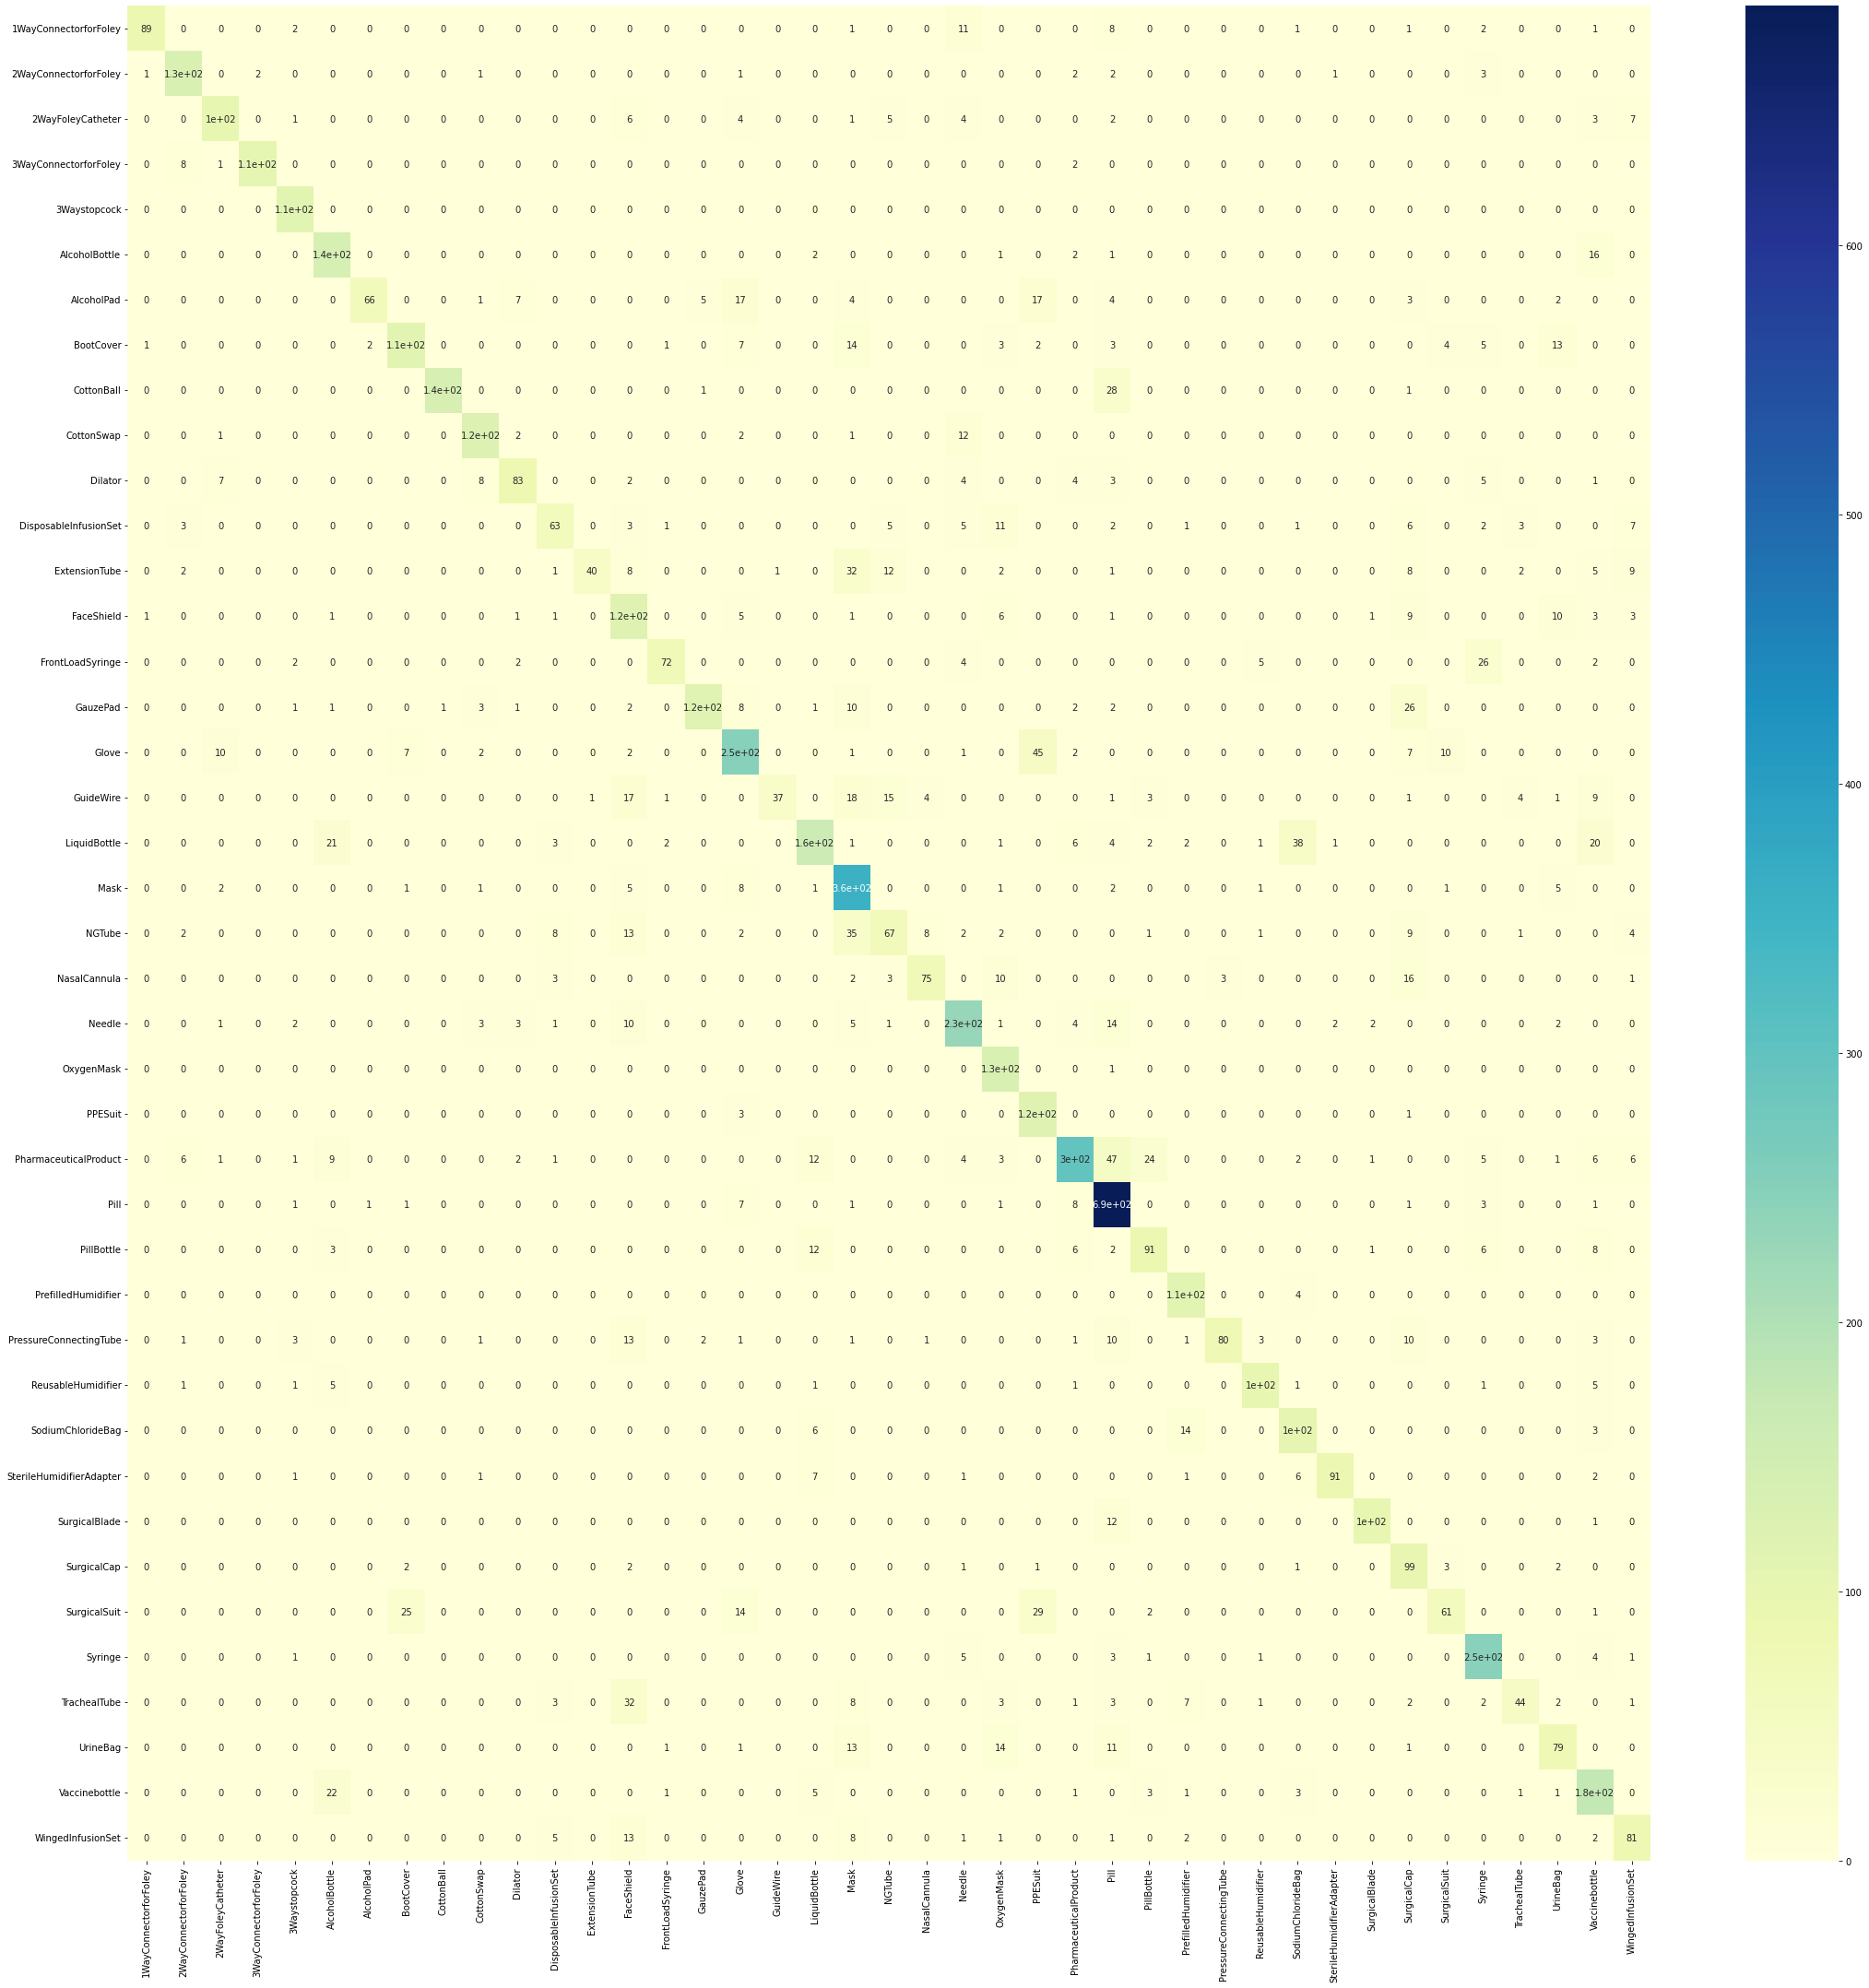

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

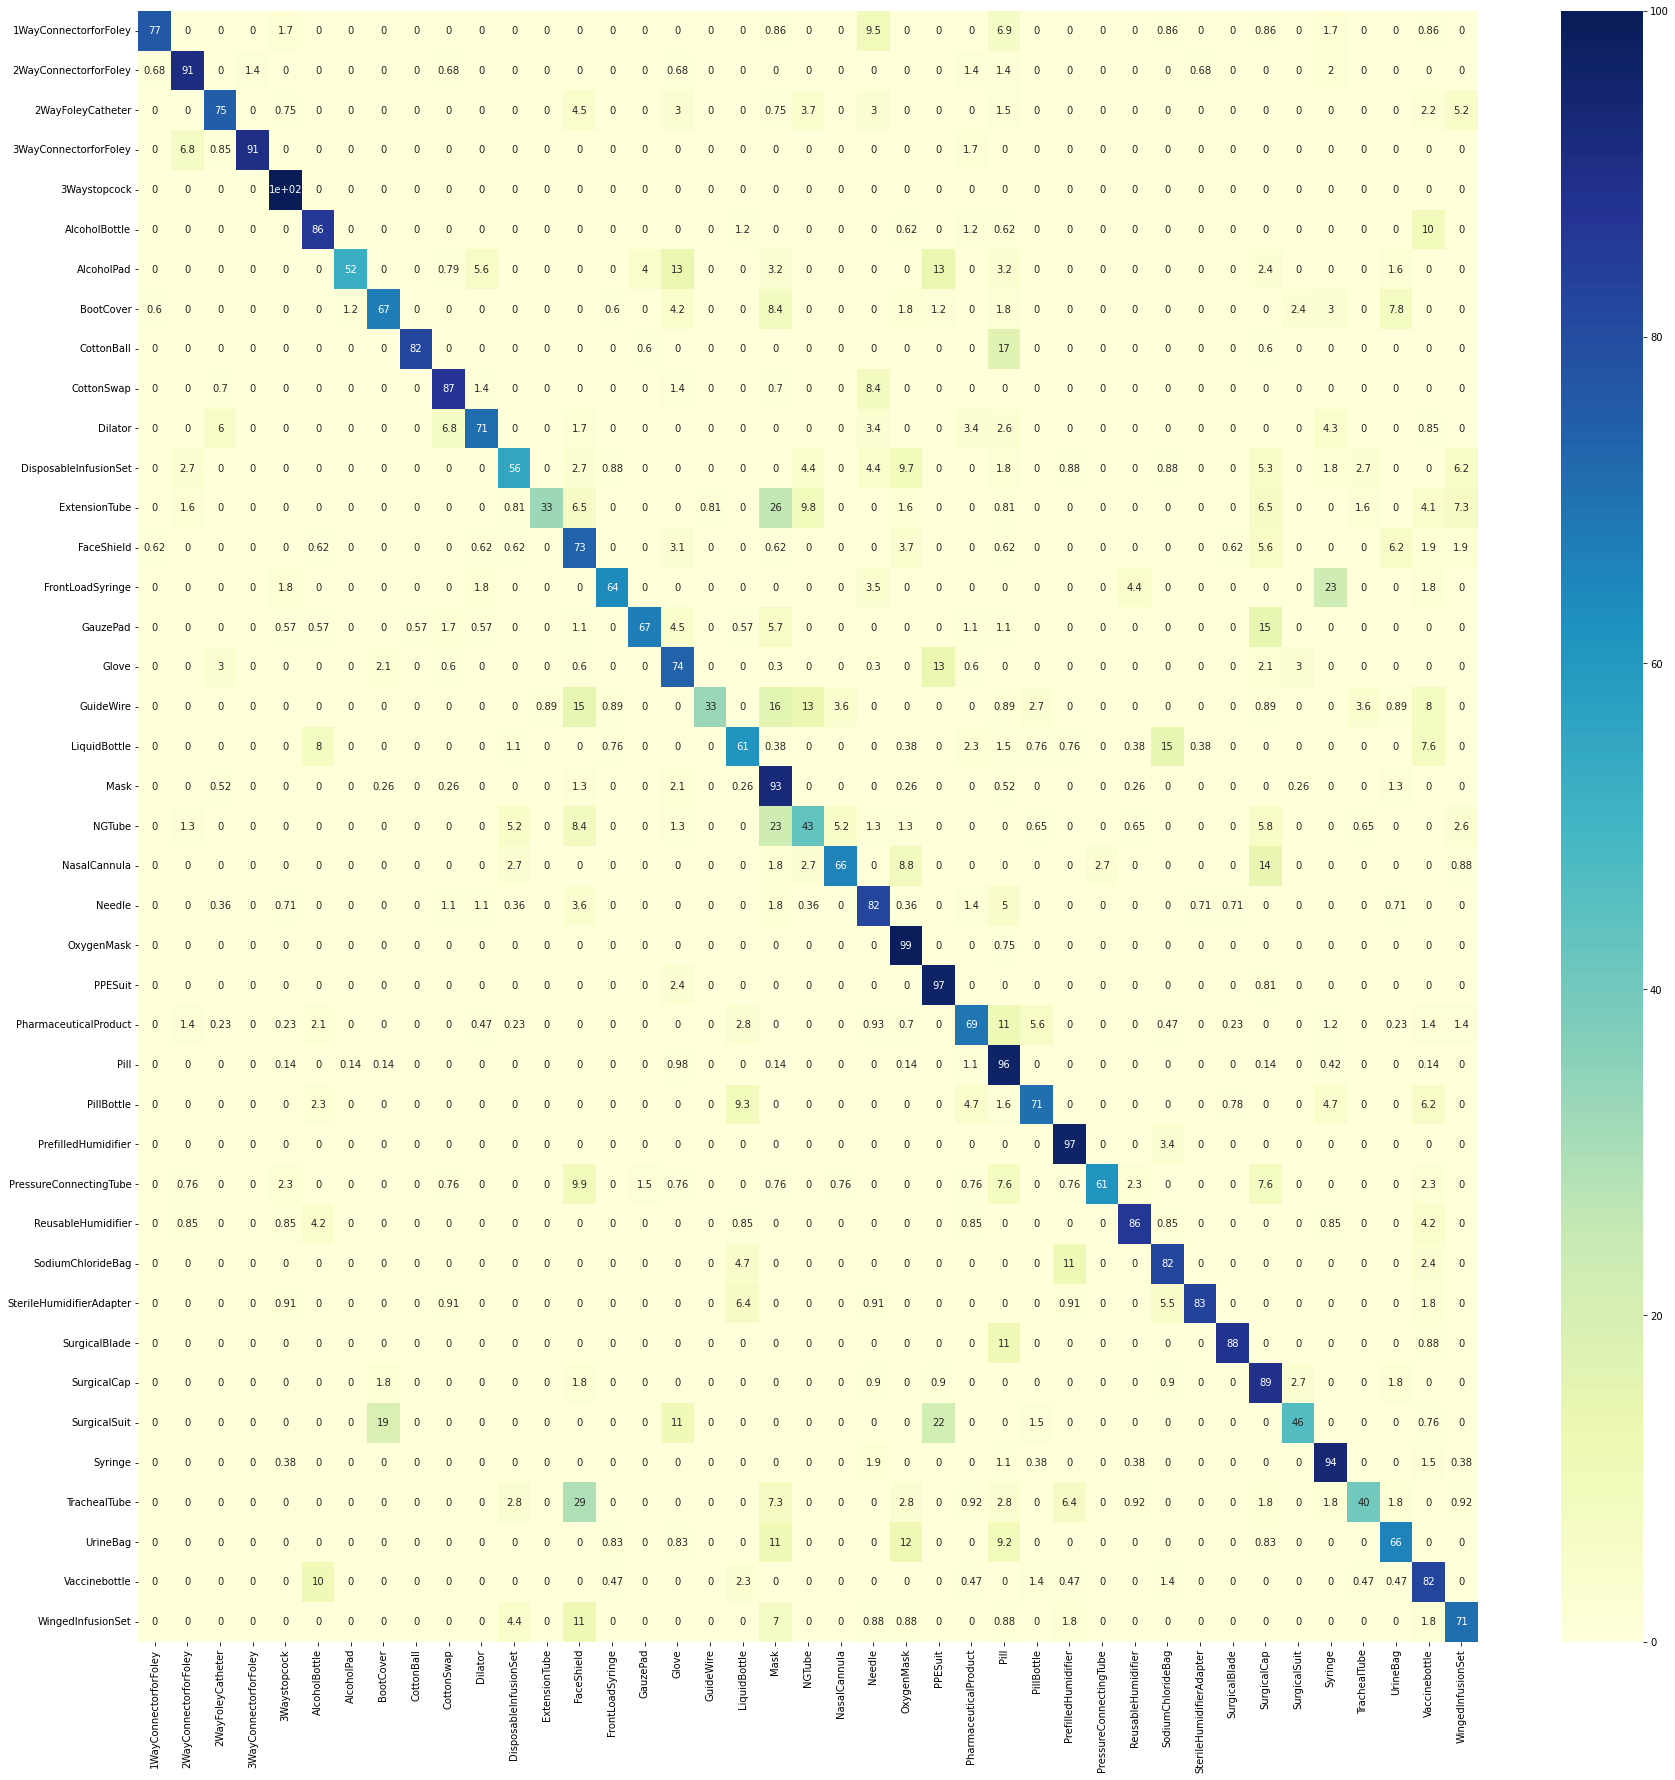

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")